In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Patch

# Load the csv files for NES and Apache Flink
df_nes = pd.read_csv("nebulastream_e2e.csv")
df_flink = pd.read_csv("flink_e2e.csv")

df_nes['system'] = 'NebulaStream'
df_flink['system'] = 'Flink'

# Rename columns for consistency
df_nes = df_nes.rename(columns={'numberOfWorkerThreads': 'parallelism', 'tuplesPerSecond': 'tuplesPerSecond_e2e', 'tuplesPerSecond_listener': 'tuplesPerSecond'})
df_flink = df_flink.rename(columns={'numOfRecords': 'numberOfRecords'})
df_flink['tuplesPerSecond_e2e'] = df_flink['tuplesPerSecond']

# Concatenate the dataframes
df_concatenated = pd.concat([df_nes, df_flink], ignore_index=True)

# Create directory if it doesn't exist
output_dir = 'system_comparison'
os.makedirs(output_dir, exist_ok=True)

df_concatenated

,bytesPerSecond,query_name,time,tuplesPerSecond_e2e,executionMode,parallelism,buffersInGlobalBufferManager,joinStrategy,numberOfEntriesSliceCaches,sliceCacheType,bufferSizeInBytes,pageSize,tuplesPerSecond,system,numberOfRecords
0,8.199428e+07,CM1,18.632543,1.000886e+06,COMPILER,1,4000000.0,HASH_JOIN,10.0,LRU,8196.0,4096.0,1.015926e+06,NebulaStream,NaN
1,8.199428e+07,CM1,18.632543,1.000886e+06,COMPILER,1,4000000.0,HASH_JOIN,10.0,LRU,8196.0,4096.0,1.015926e+06,NebulaStream,NaN
2,1.261053e+08,CM1,12.114975,1.539339e+06,COMPILER,2,4000000.0,HASH_JOIN,10.0,LRU,8196.0,4096.0,1.517461e+06,NebulaStream,NaN
3,1.261053e+08,CM1,12.114975,1.539339e+06,COMPILER,2,4000000.0,HASH_JOIN,10.0,LRU,8196.0,4096.0,1.517461e+06,NebulaStream,NaN
4,1.909020e+08,CM1,8.002860,2.330299e+06,COMPILER,4,4000000.0,HASH_JOIN,10.0,LRU,8196.0,4096.0,2.371504e+06,NebulaStream,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,NaN,NM8_Variant,NaN,9.317930e+05,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,9.317930e+05,Flink,20000000.0
221,NaN,NM8_Variant,NaN,1.241744e+06,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,1.241744e+06,Flink,20000000.0
222,NaN,NM8_Variant,NaN,2.101198e+06,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,2.101198e+06,Flink,20000000.0
223,NaN,NM8_Variant,NaN,2.462213e+06,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,2.462213e+06,Flink,20000000.0


15 2305129.0 7 1.6891351609582133 0
16 853707.0 8 7.950502924305412 1
17 284336.0 8 125.4076163412301 2
18 1130869.0 9 28.73510226528127 3
19 176949.0 9 33.175284027224414 4
20 25001.0 10 63.707308850503125 5
21 17091.0 10 10.657808459813792 6
22 338790.0 11 15.350269037040123 7
23 8613297.0 11 4.94124707082881 8
24 8532161.0 12 5.493059339441281 9
25 4856945.0 12 14.168279763422388 10
26 1415534.0 13 1.8407576222118296 11
27 2120603.0 13 4.71712899337445 12
28 2035617.0 14 0.8970744496631734 13
29 2028299.0 14 1.1952438307501343 14


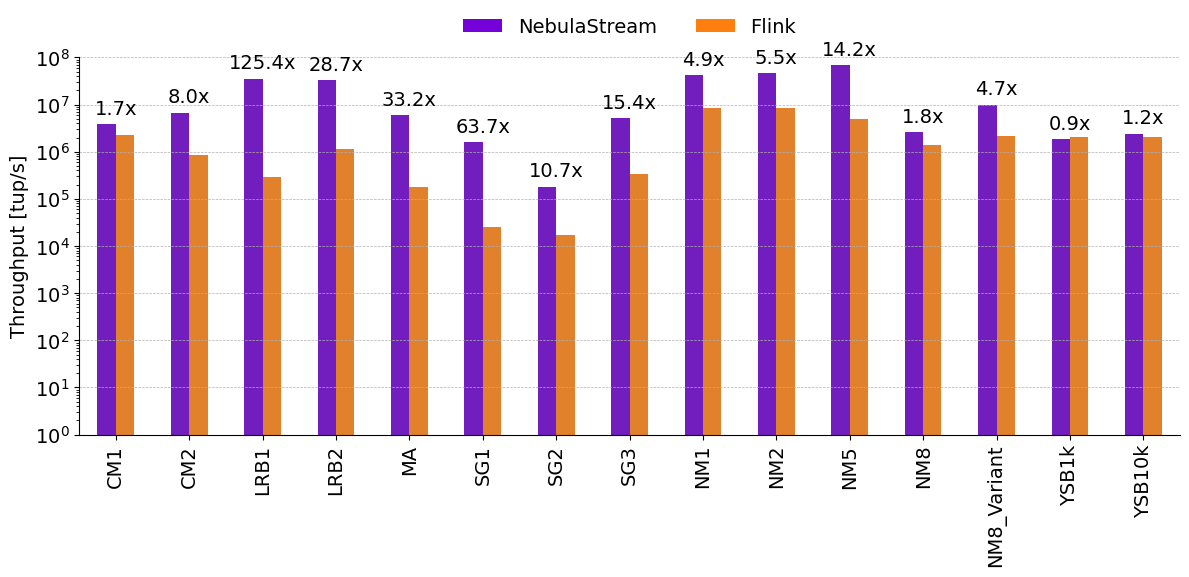

In [2]:
# Filter data for numberOfWorkerThreads == 16
noThreads = 16
df_filtered = df_concatenated[df_concatenated['parallelism'] == noThreads]
hue_order = ['NebulaStream', 'Flink']
custom_palette = ["#7402d8", "#ff7f0e"]
legend_handles = [
    Patch(facecolor=custom_palette[0], label='NebulaStream'),
    Patch(facecolor=custom_palette[1], label='Flink')
]

#df_filtered = df_concatenated
# Create and save the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_filtered, x='query_name', y='tuplesPerSecond', hue='system', palette=custom_palette, hue_order=hue_order, dodge=0.2, width=0.5)
#plt.title(f'Tuples per Second for numberOfWorkerThreads == {noThreads}')
plt.xticks(rotation=90, fontsize=14)
plt.xlabel("")
plt.ylabel("Throughput [tup/s]", fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.ylim(1)
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate the bars with values in millions per second
for pid, p in enumerate(ax.patches):
    pos_baseline = pid
    if pos_baseline >= (len(ax.patches) // 2 - 1):
        pos_baseline -= (len(ax.patches) // 2 - 1)
    baseline_height = ax.patches[pos_baseline].get_height()
    if pid >= (len(ax.patches) // 2 - 1) and p.get_height() > 0:
        speedup = baseline_height / p.get_height()
        print(pid, p.get_height(), pid//2, speedup, pos_baseline)
        ax.annotate(f'{speedup:.1f}x',
                    (p.get_x(), baseline_height * 1.5),
                    ha='center', va='center', xytext=(0, 5),
                    textcoords='offset points', fontsize=14, rotation=0)

plt.legend(title='', handles=legend_handles, fontsize=14, title_fontsize=14, labels=hue_order,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=2,
    frameon=False)        
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'system_comparison.pdf'))
plt.show()
plt.close()

15 2305129.0 7 1.6203290006212903 0
16 853707.0 8 7.43196469187749 1
17 284336.0 8 53.81090039512195 2
18 1130869.0 9 6.0175837439089666 3
19 176949.0 9 35.70246332565864 4
20 25001.0 10 63.21836933565166 5
21 17091.0 10 10.516467995894267 6
22 338790.0 11 15.382470727037525 7
23 8613297.0 11 5.6241409653329 8
24 8532161.0 12 5.544073960675507 9
25 4856945.0 12 11.353037115316935 10
26 1415534.0 13 1.7908727126354729 11
27 2120603.0 13 4.760704927445573 12
28 2035617.0 14 0.8981868642412139 13
29 2028299.0 14 1.2909902050274957 14


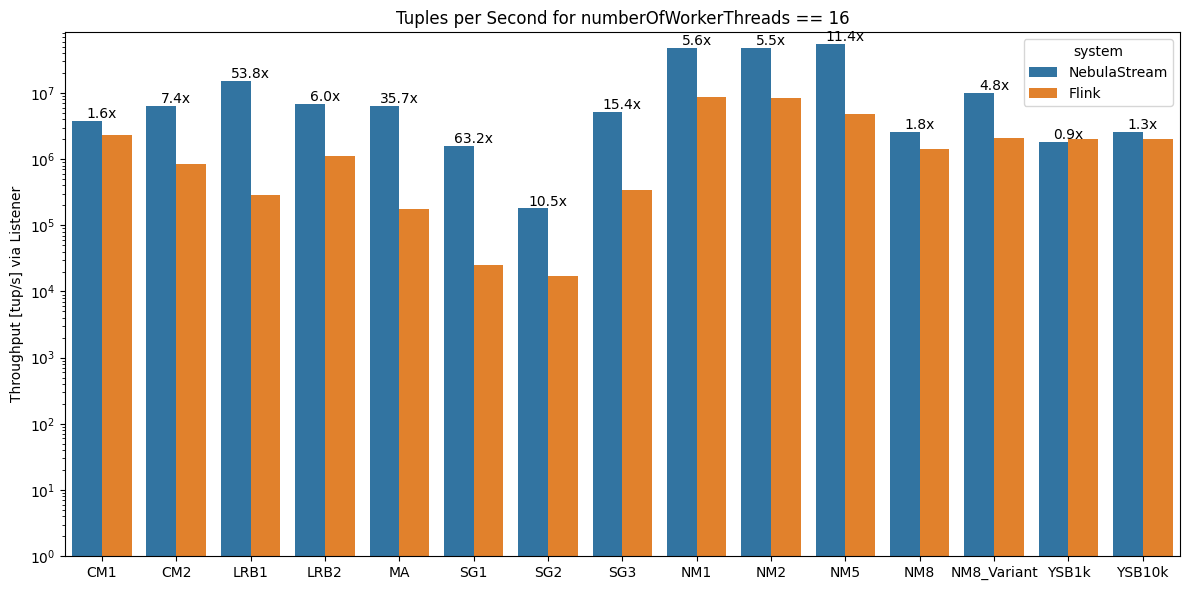

In [3]:
# Filter data for numberOfWorkerThreads == 16
noThreads = 16
df_filtered = df_concatenated[df_concatenated['parallelism'] == noThreads]
#df_filtered = df_concatenated
# Create and save the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_filtered, x='query_name', y='tuplesPerSecond_e2e', hue='system')
plt.title(f'Tuples per Second for numberOfWorkerThreads == {noThreads}')
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Throughput [tup/s] via Listener")
plt.yscale('log')
plt.ylim(1)

# Annotate the bars with values in millions per second
for pid, p in enumerate(ax.patches):
    pos_baseline = pid
    if pos_baseline >= (len(ax.patches) // 2 - 1):
        pos_baseline -= (len(ax.patches) // 2 - 1)
    baseline_height = ax.patches[pos_baseline].get_height()
    if pid >= (len(ax.patches) // 2 - 1) and p.get_height() > 0:
        speedup = baseline_height / p.get_height()
        print(pid, p.get_height(), pid//2, speedup, pos_baseline)
        ax.annotate(f'{speedup:.1f}x',
                    (p.get_x(), baseline_height),
                    ha='center', va='center', xytext=(0, 5),
                    textcoords='offset points')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'system_comparison_e2e.pdf'))
plt.show()
plt.close()

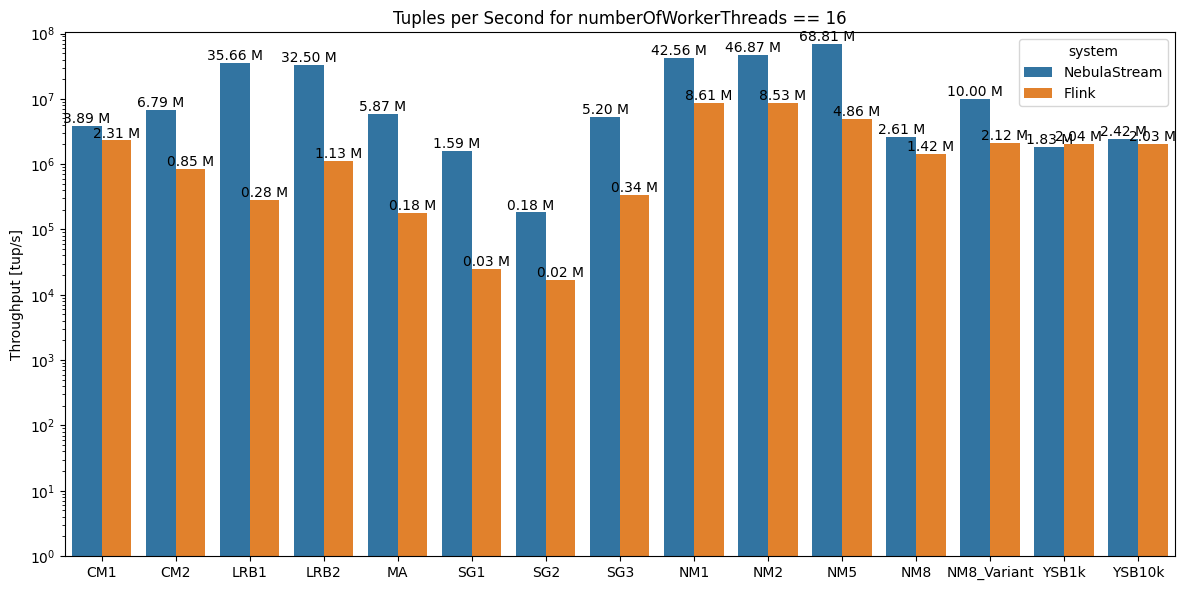

In [4]:
# Filter data for numberOfWorkerThreads == 16
noThreads = 16
df_filtered = df_concatenated[df_concatenated['parallelism'] == noThreads]
#df_filtered = df_concatenated
# Create and save the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_filtered, x='query_name', y='tuplesPerSecond', hue='system')
plt.title(f'Tuples per Second for numberOfWorkerThreads == {noThreads}')
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Throughput [tup/s]")
plt.yscale('log')
plt.ylim(1)
# Annotate the bars with values in millions per second
for p in ax.patches:
    ax.annotate(f'{p.get_height() / 1e6:.2f} M',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'system_comparison_abs_values.pdf'))
plt.show()
plt.close()

/tmp/ipykernel_35802/2759087891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
/tmp/ipykernel_35802/2759087891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


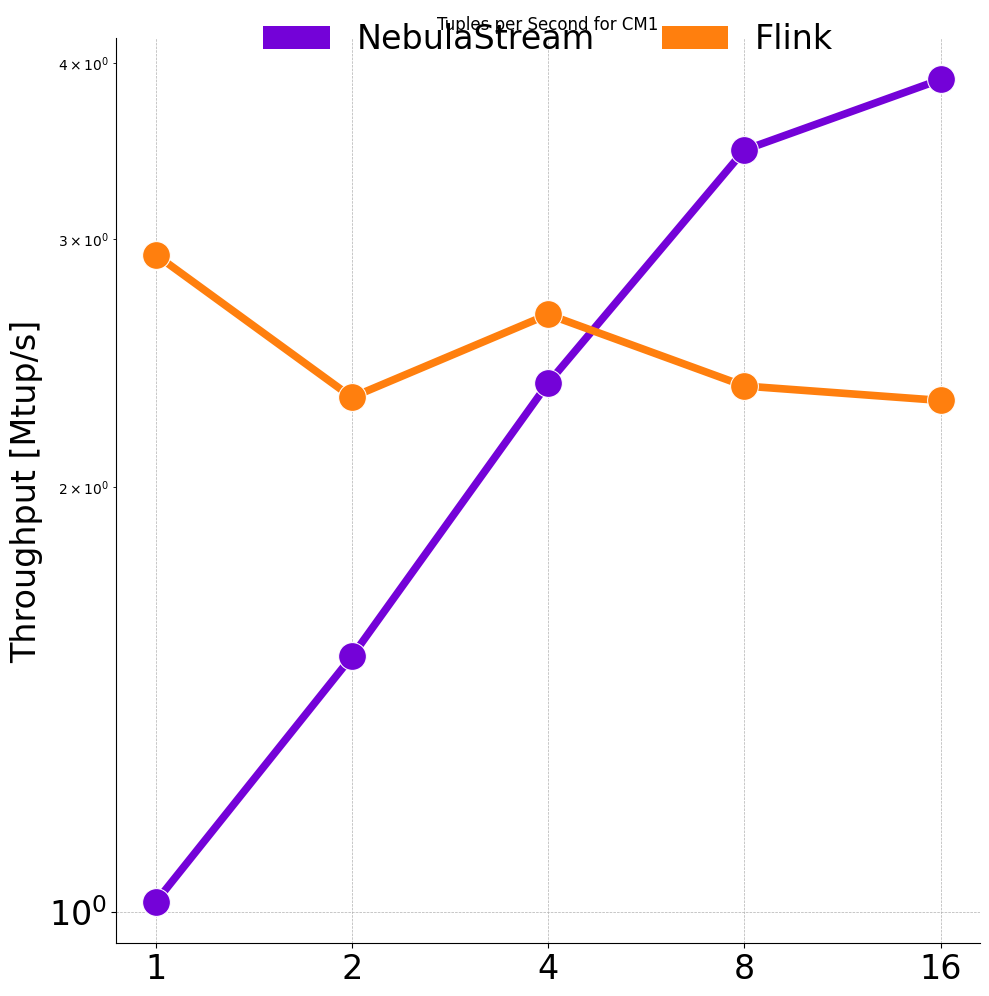

/tmp/ipykernel_35802/2759087891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
/tmp/ipykernel_35802/2759087891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


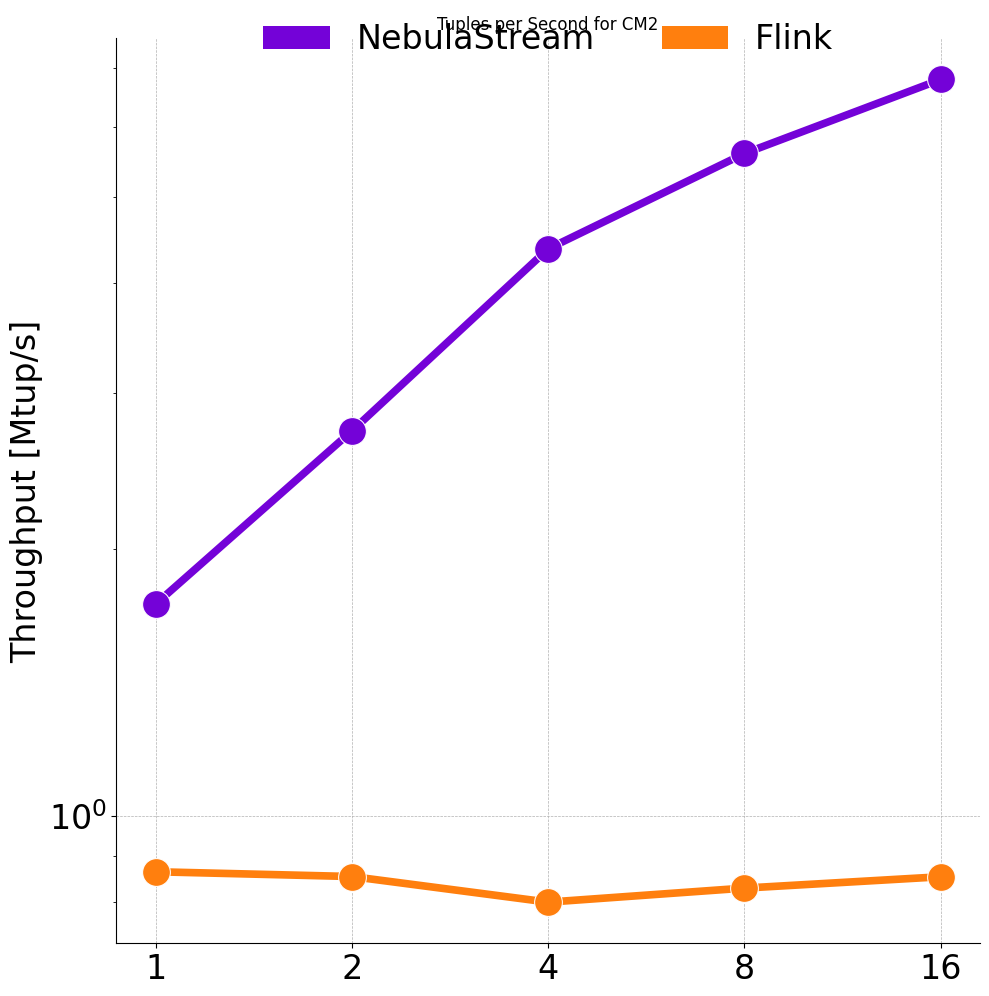

/tmp/ipykernel_35802/2759087891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
/tmp/ipykernel_35802/2759087891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


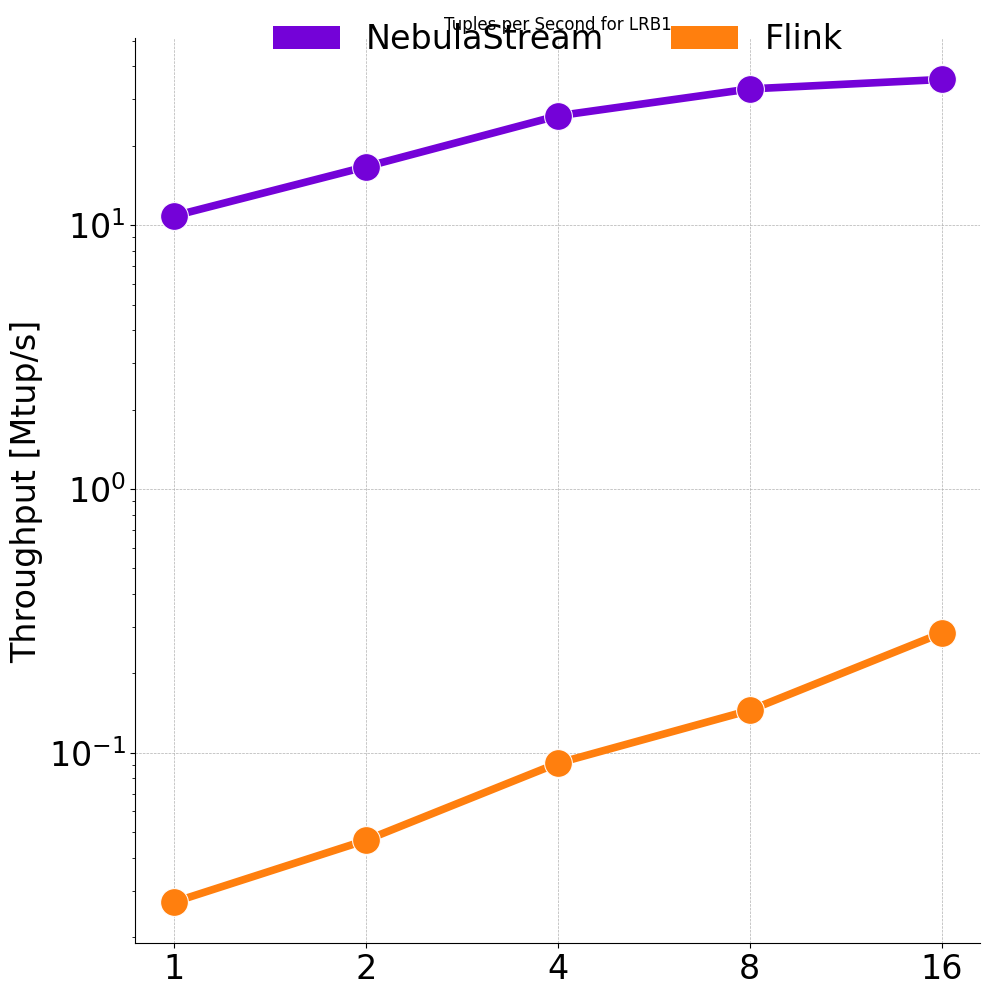

/tmp/ipykernel_35802/2759087891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
/tmp/ipykernel_35802/2759087891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


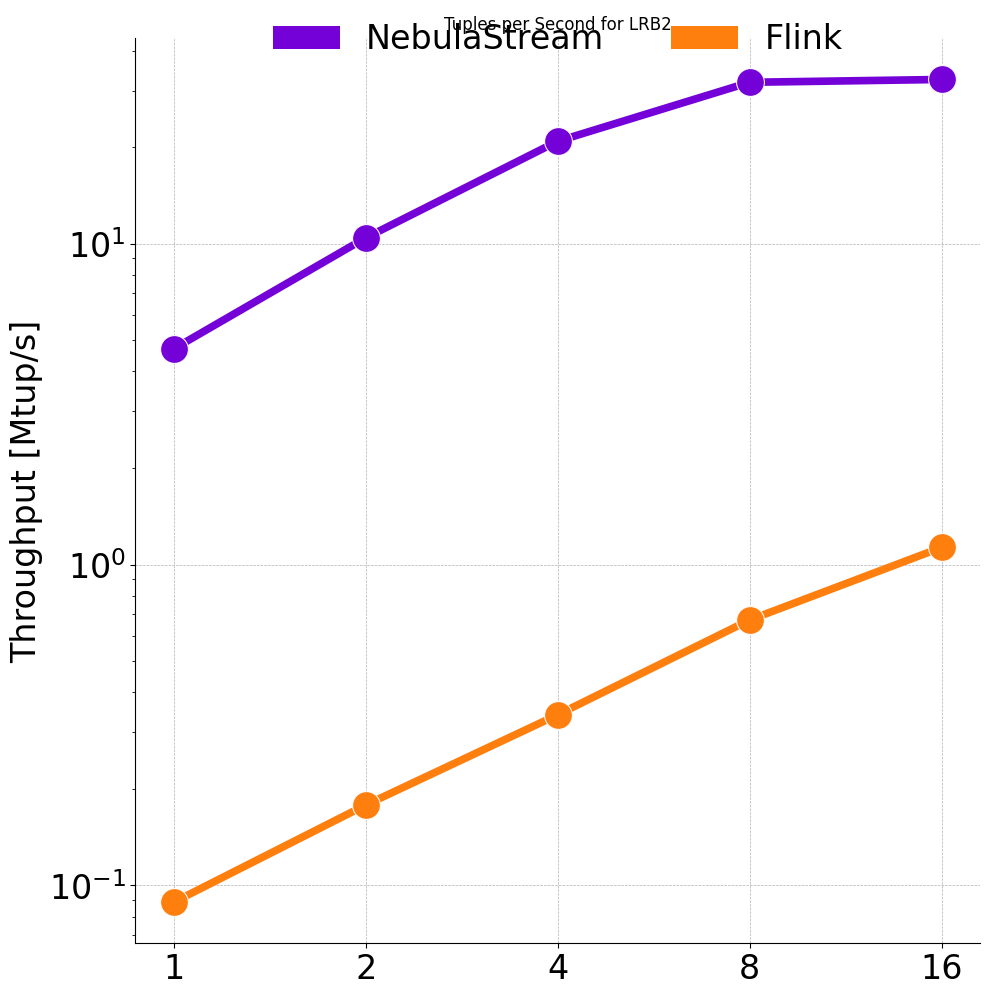

/tmp/ipykernel_35802/2759087891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
/tmp/ipykernel_35802/2759087891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


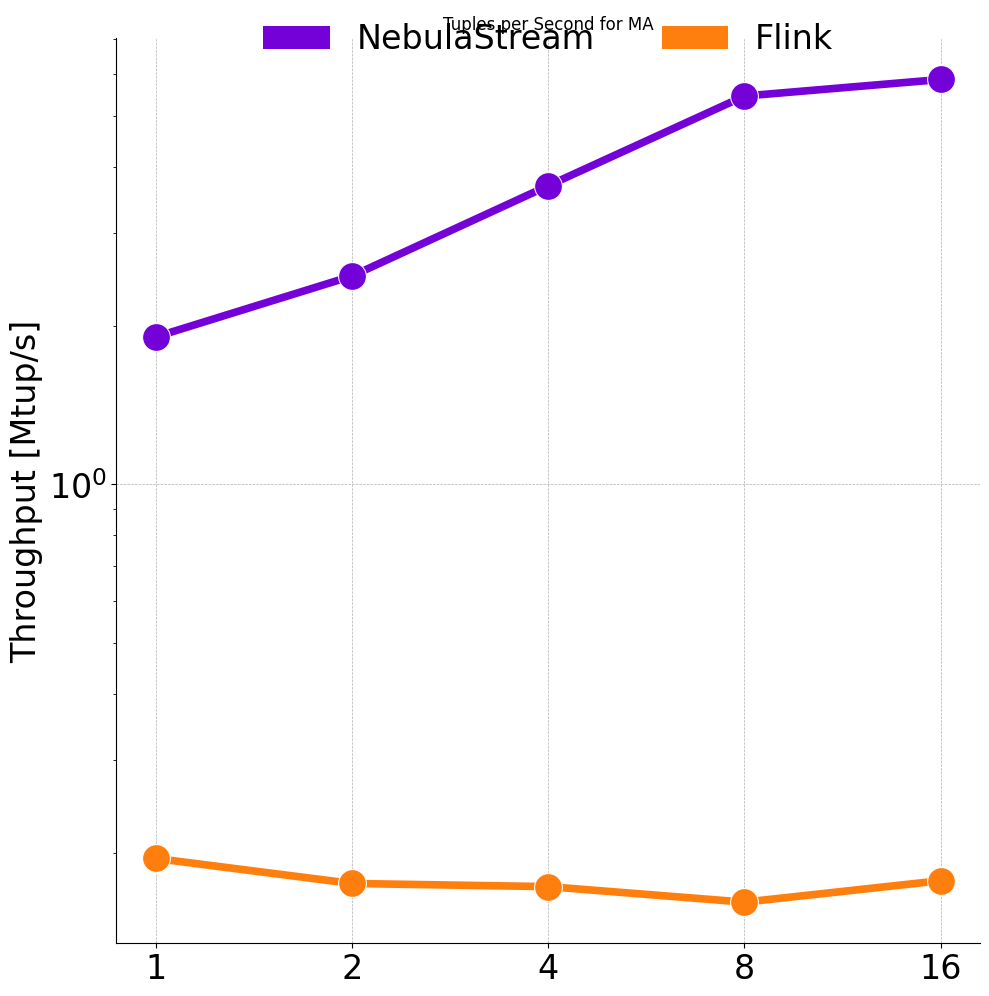

/tmp/ipykernel_35802/2759087891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
/tmp/ipykernel_35802/2759087891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


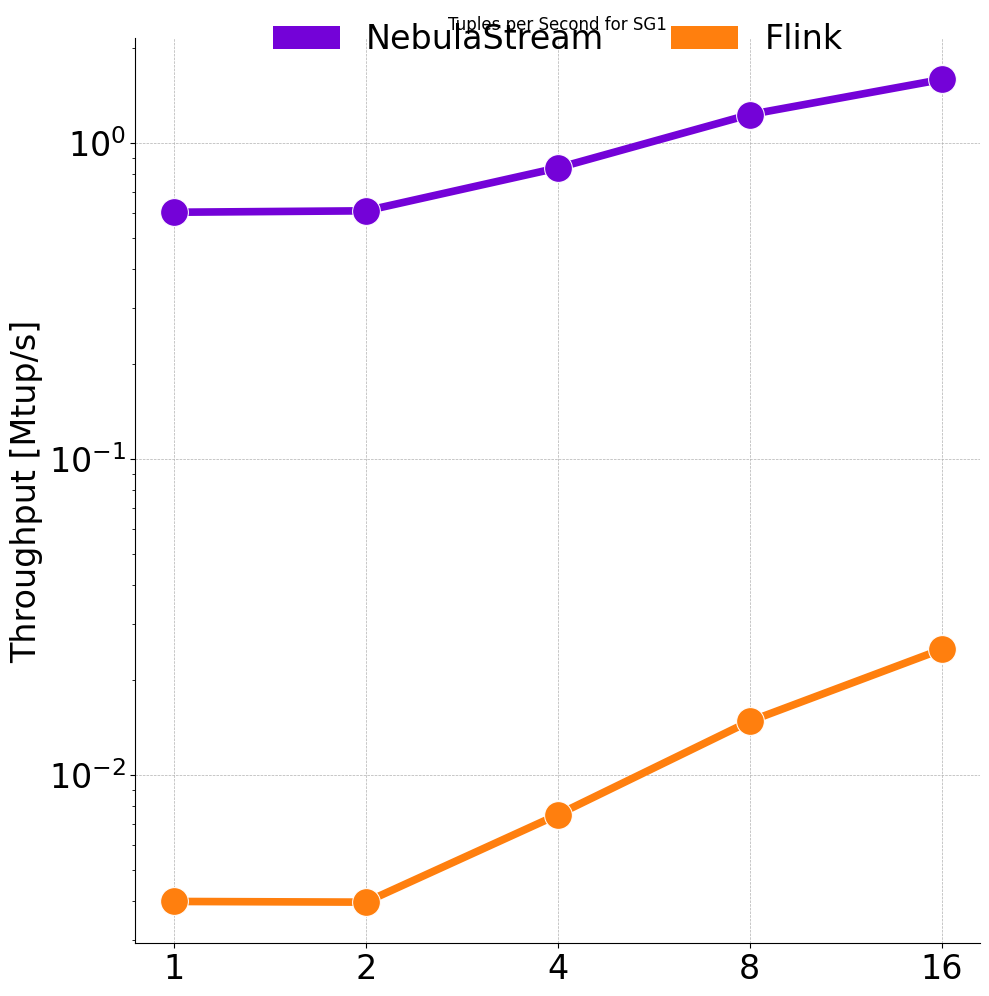

/tmp/ipykernel_35802/2759087891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
/tmp/ipykernel_35802/2759087891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


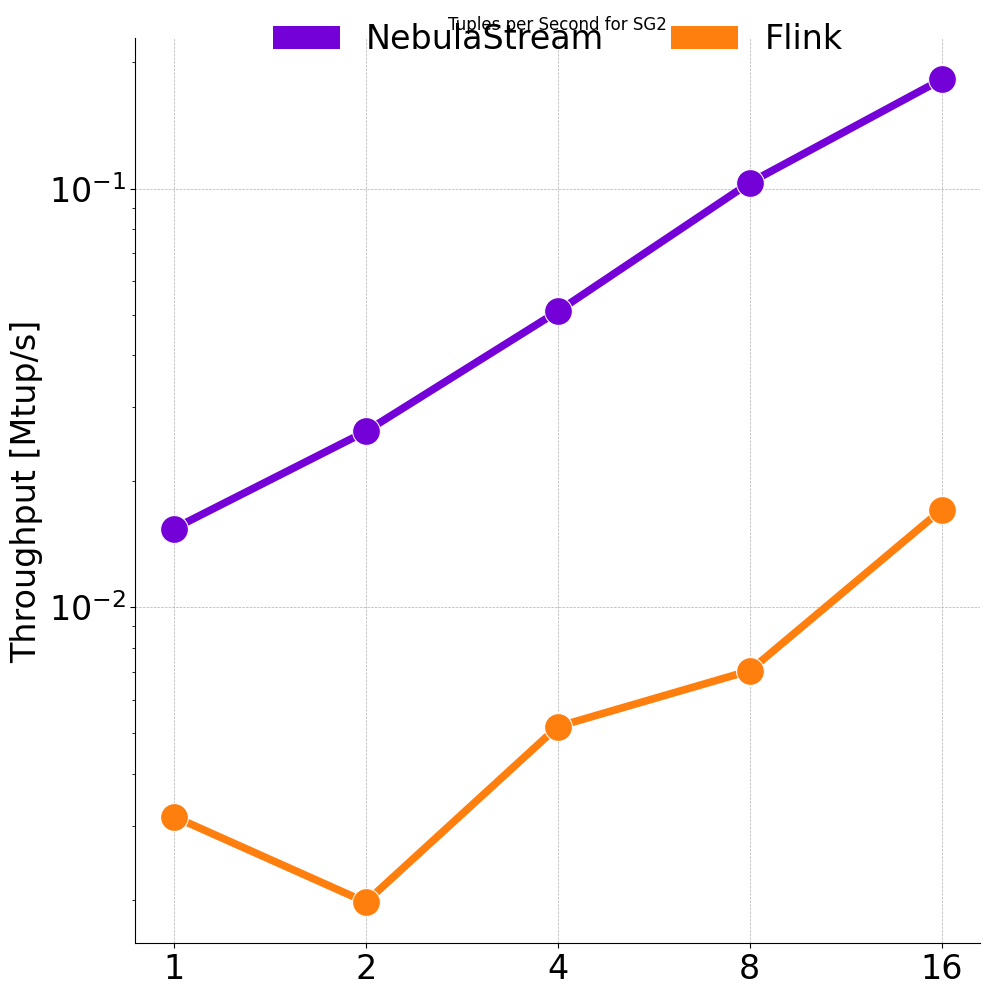

/tmp/ipykernel_35802/2759087891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
/tmp/ipykernel_35802/2759087891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


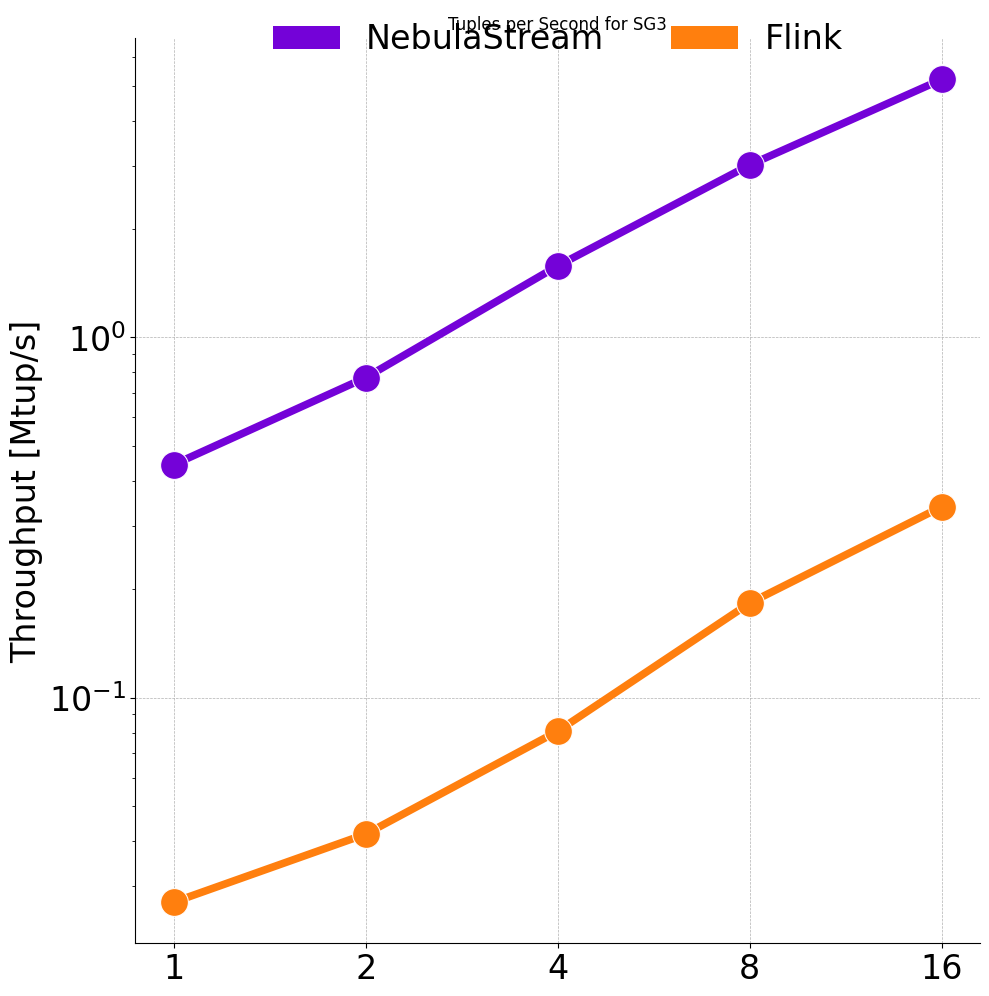

/tmp/ipykernel_35802/2759087891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
/tmp/ipykernel_35802/2759087891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


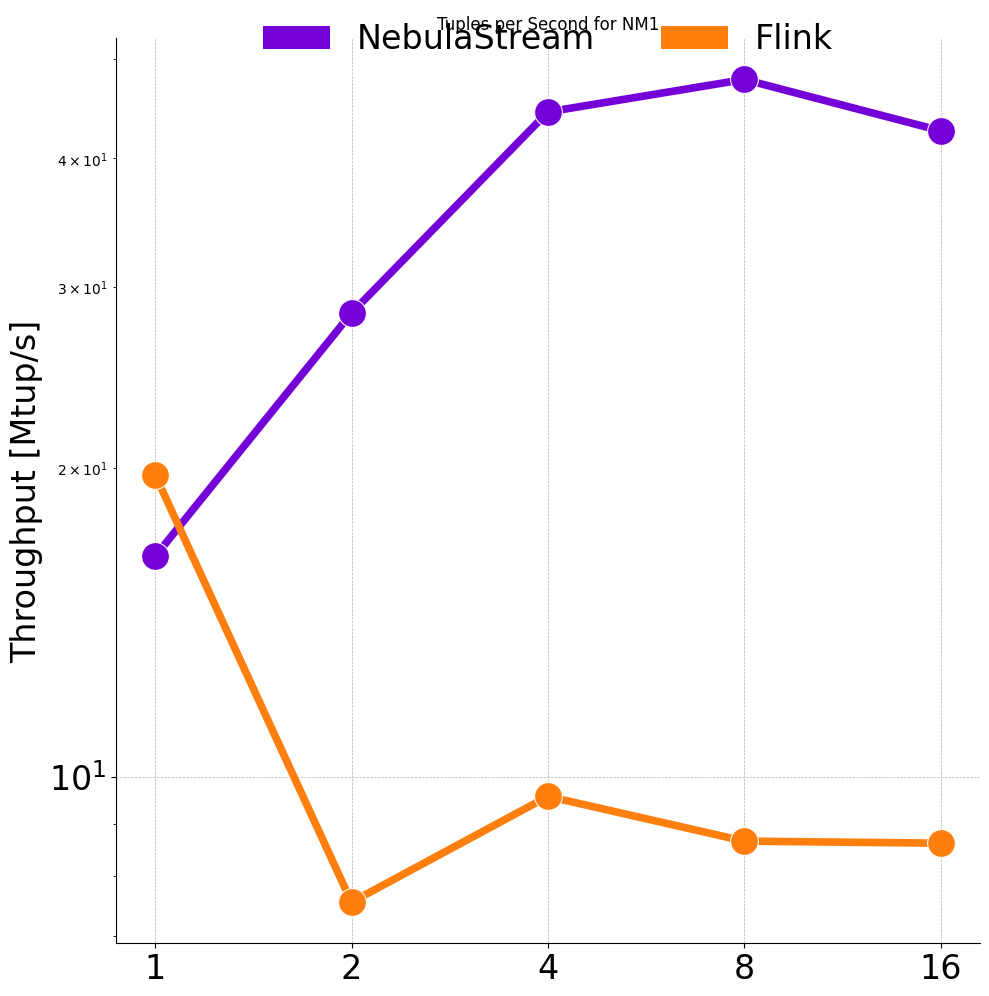

/tmp/ipykernel_35802/2759087891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
/tmp/ipykernel_35802/2759087891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


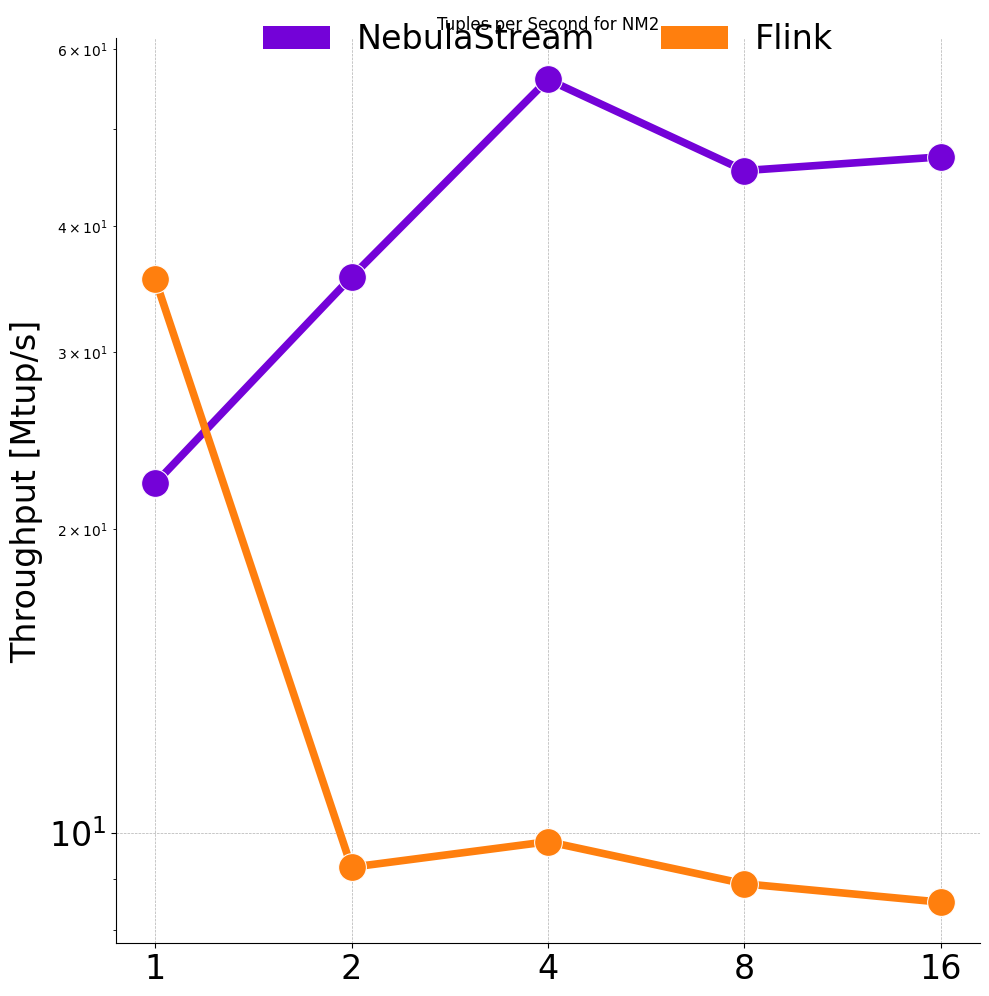

/tmp/ipykernel_35802/2759087891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
/tmp/ipykernel_35802/2759087891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


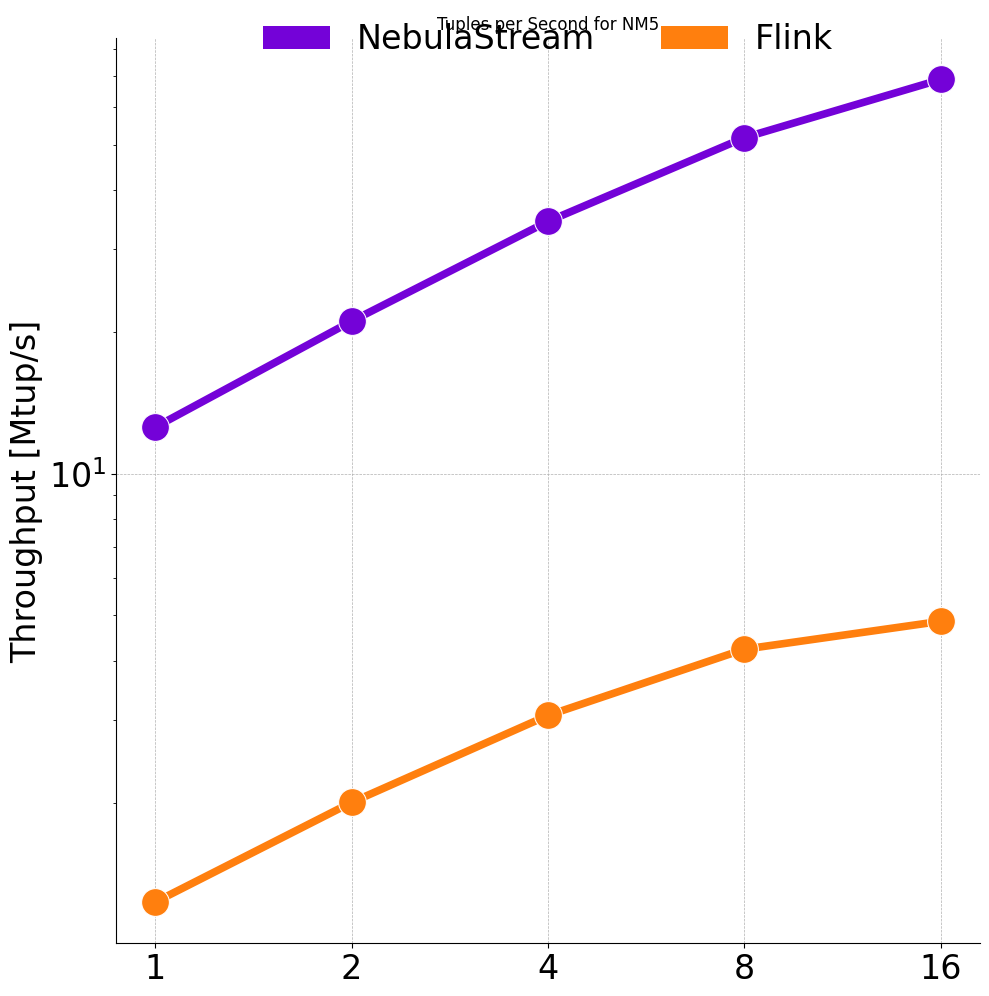

/tmp/ipykernel_35802/2759087891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
/tmp/ipykernel_35802/2759087891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


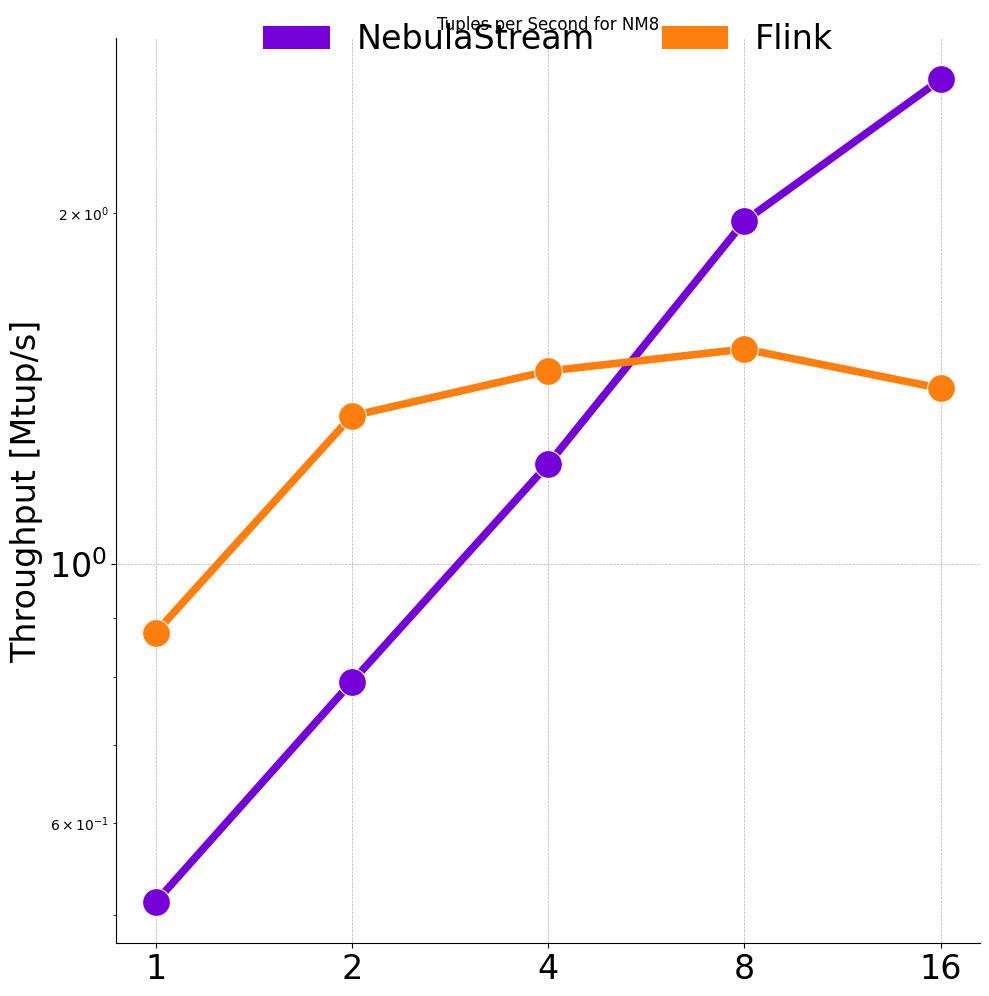

/tmp/ipykernel_35802/2759087891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
/tmp/ipykernel_35802/2759087891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


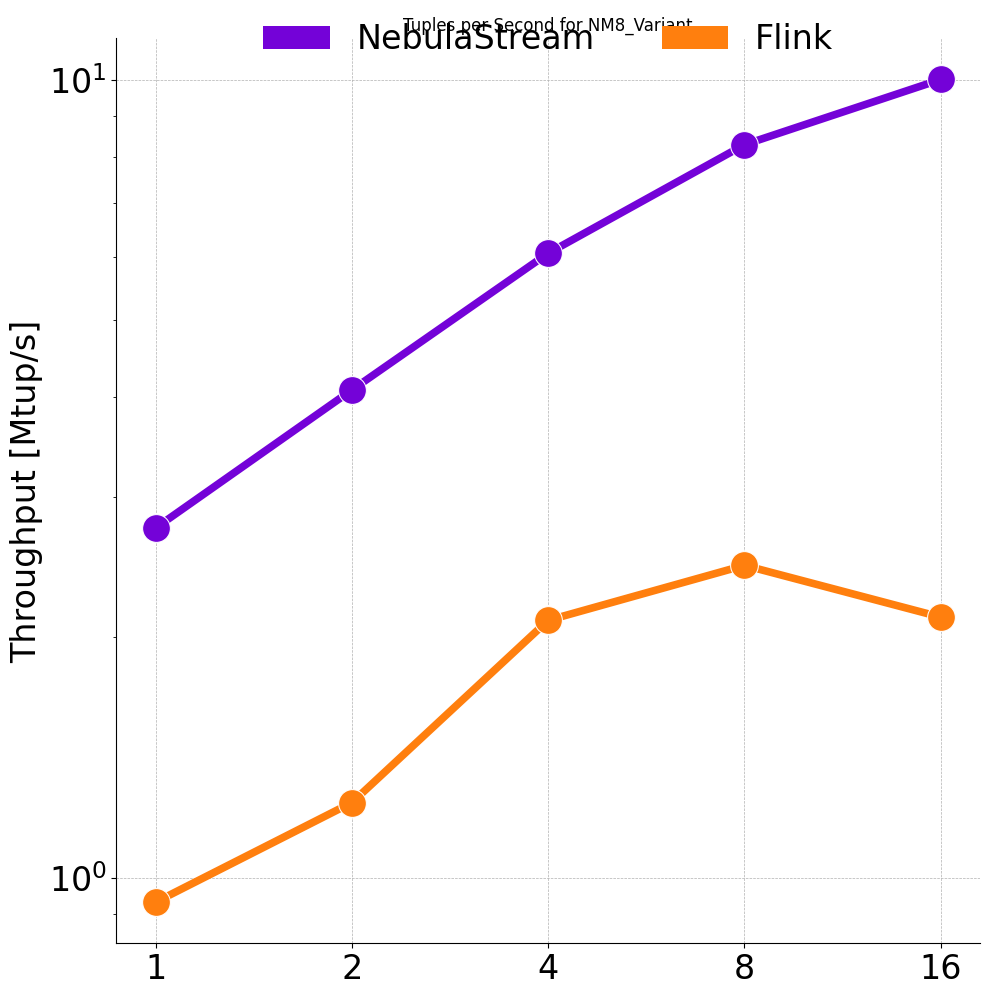

/tmp/ipykernel_35802/2759087891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
/tmp/ipykernel_35802/2759087891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


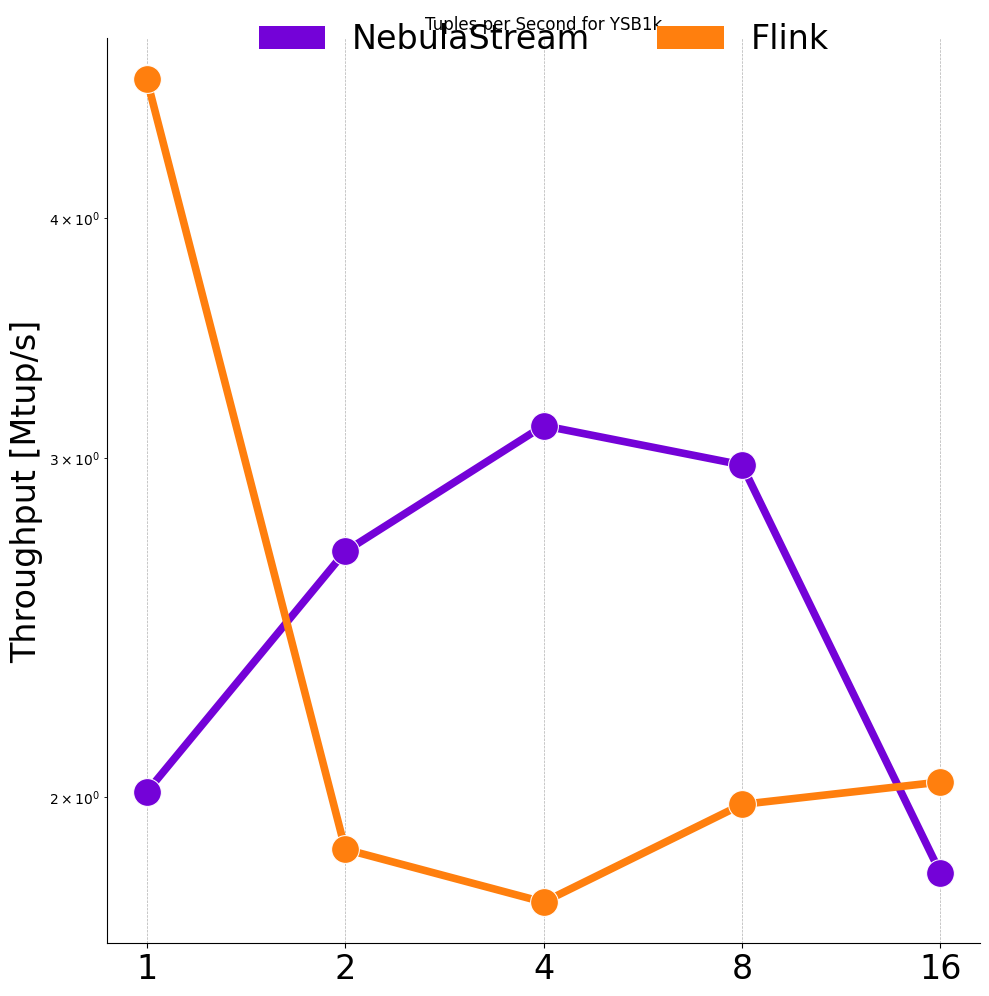

/tmp/ipykernel_35802/2759087891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
/tmp/ipykernel_35802/2759087891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


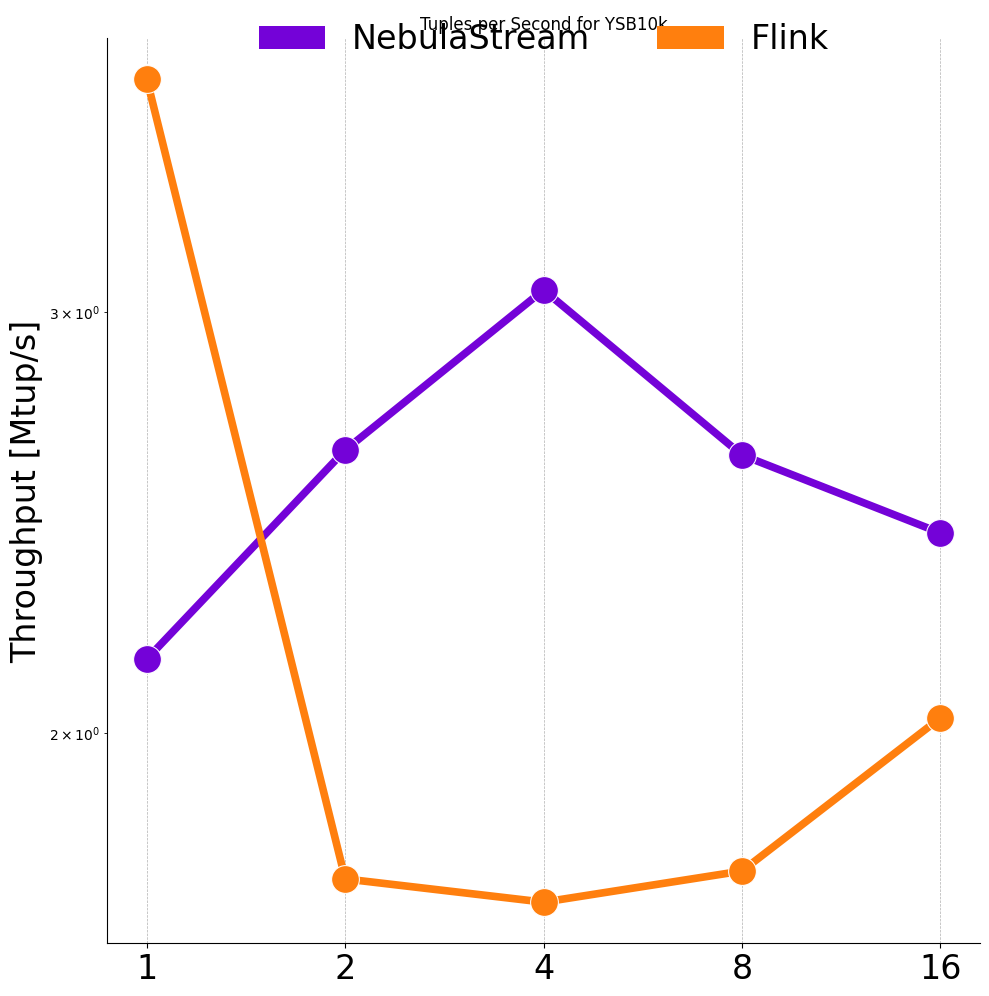

In [5]:
# Create and save line plots for each query_name
queries = df_concatenated['query_name'].unique()
for query in queries:
    df_query = df_concatenated[df_concatenated['query_name'] == query]
    df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond'] / 1e6
    df_query['parallelism_str'] = df_query['parallelism'].astype(str)
    plt.figure(figsize=(10, 10))
    ax = sns.lineplot(data=df_query, x='parallelism_str', y='millionTuplesPerSecond', hue='system', marker='o', markersize=20, linewidth=5.5, palette=custom_palette, hue_order=hue_order)
    custom_palette = ["#7402d8", "#ff7f0e"]
    legend_handles = [
        Patch(facecolor=custom_palette[0], label='NebulaStream'),
        Patch(facecolor=custom_palette[1], label='Flink')
    ]
    plt.legend(title='', handles=legend_handles, fontsize=24, title_fontsize=14, labels=hue_order,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=2,
    frameon=False)
    plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(f'Tuples per Second for {query}')
    plt.xticks(rotation=0, fontsize=24)
    plt.xlabel("")
    plt.ylabel("Throughput [Mtup/s]", fontsize=24)
    plt.yticks(fontsize=24)
    plt.yscale('log')
    #plt.ylim(1)
    plt.tight_layout()
    filename = f"{query}_parallelism_tuplesPerSecond.pdf"
    plt.savefig(os.path.join(output_dir, filename))
    plt.show()
    plt.close()